In [1]:
from efficientkan import KAN
from utils import *

import numpy as np
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load and display dataset. Available datasets: Auto MPG (id=9), Airfoil self noise (id=291), Appliances energy prediction (id=374)

ds_id = 374
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X, y, trainloader, testloader, valloader, input_size = get_regr_dataset(device, ds_id=ds_id, batch_size=64, test_size=0.2)
X.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [3]:
y.head()

,G3
0,11
1,11
2,12
3,14
4,13


In [3]:
class MyMLP(nn.Module):

    def __init__(self, layers: list):
        super(MyMLP, self).__init__()

        self.layers = layers
        to_sequential, self.num_parameters = self.build_layers_and_count_params(layers)
        self.build_layers = nn.Sequential(*to_sequential)

    def forward(self, x):
        return self.build_layers(x)


    # given a list of layer sizes, builds the respective linear layers with ReLU activation functions.
    # Also returns the total number of parameters of the model.
    def build_layers_and_count_params(self, layers):

        to_sequential = []
        num_parameters = 0

        for i in range(len(layers) - 1):

            to_sequential.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                to_sequential.append(nn.ReLU())

            num_parameters += layers[i]*layers[i+1] + layers[i+1]

        return to_sequential, num_parameters



class MyKAN(nn.Module):

    def __init__(self, layers: list, grid_size):
        super(MyKAN, self).__init__()

        self.layers = layers
        self.num_parameters = self.count_params(layers, grid_size)
        self.build_layers = KAN(layers, grid_size=grid_size)


    def forward(self, x):
        return self.build_layers(x)


    def count_params(self, layers, grid_size):

        num_parameters = 0

        for i in range(len(layers) - 1):
            num_parameters += layers[i]*layers[i+1]

        return num_parameters * grid_size

In [4]:
def train_and_test(model, trainloader, valloader, testloader, device, num_epochs, optimizer, criterion):

    lr = optimizer.param_groups[0]['lr']
    print(f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} and parameters:' if device=='cpu' else f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} ({torch.cuda.get_device_name()}) and parameters:')
    print(f'\tLearning rate: {lr}\n\tLoss function: {criterion.__class__.__name__}\n\tOptimizer: {optimizer.__class__.__name__}\n')
    print(f'Number of parameters: {model.num_parameters}\n')

    model.to(device)

    train_losses = []
    val_losses = []
    times = []

    # Train & validation

    for epoch in range(num_epochs):

        model.train()
        train_loss = 0
        start = time()

        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(trainloader))

        t = time()-start
        times.append(t)


        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for inputs, labels in valloader:
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(valloader))

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(trainloader):.4f}, Validation Loss: {val_loss/len(valloader):.4f}, Avg epoch time: {t:.4f}s')


    # Test

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for inputs, labels in testloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

        print(f'Test Loss: {test_loss/len(testloader):.4f}\nTotal training time: {sum(times):.4f}\n')


    return train_losses, val_losses, test_loss/len(testloader), times

In [ ]:
# Define models and parameters

model_list_mlp = [
    MyMLP([input_size, 14, 1]),
    MyMLP([input_size, 20, 16, 12, 1]),
    MyMLP([input_size, 136, 1]),
    MyMLP([input_size, 128, 64, 64, 1]),
    ]
model_list_kan = [
    MyKAN([input_size, 5, 1], grid_size=3),
    MyKAN([input_size, 10, 10, 5, 1], grid_size=3),
    MyKAN([input_size, 50, 1], grid_size=3),
    MyKAN([input_size, 64, 42, 32, 1], grid_size=3),
    ]

num_epochs = 200
learning_rate = 0.001
criterion = RMSELoss()

lists = [[] for _ in range(10)]
total_train_losses_mlp, total_val_losses_mlp, total_train_losses_kan, total_val_losses_kan, test_losses_mlp, test_losses_kan, num_params_mlp, num_params_kan, total_times_mlp, total_times_kan = lists

for model_mlp, model_kan in zip(model_list_mlp, model_list_kan):

    optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
    train_losses_mlp, val_losses_mlp, test_loss_mlp, times_mlp = train_and_test(model_mlp, trainloader, valloader, testloader, device, num_epochs, optimizer_mlp, criterion)
    total_train_losses_mlp.append(train_losses_mlp)
    total_val_losses_mlp.append(val_losses_mlp)
    test_losses_mlp.append(test_loss_mlp)
    num_params_mlp.append(model_mlp.num_parameters)
    total_times_mlp.append(times_mlp)

    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses_kan, val_losses_kan, test_loss_kan, times_kan = train_and_test(model_kan, trainloader, valloader, testloader, device, num_epochs, optimizer_kan, criterion)
    total_train_losses_kan.append(train_losses_kan)
    total_val_losses_kan.append(val_losses_kan)
    test_losses_kan.append(test_loss_kan)
    num_params_kan.append(model_kan.num_parameters)
    total_times_kan.append(times_kan)


In [ ]:
print(total_train_losses_mlp)
print(total_val_losses_mlp)

print(total_train_losses_kan)
print(total_val_losses_kan)

In [8]:
def display_regr_loss(ds_name, model_list, total_train_losses, total_val_losses, num_epochs):
    '''
    Displays train/validation loss w.r.t epochs.
    '''

    fig, ax = plt.subplots(figsize=(4,4))

    colors = plt.cm.tab10.colors

    for i, model in enumerate(model_list):

        base_color = colors[i % len(colors)]
        
        ax.plot(range(1, num_epochs + 1), total_train_losses[i], color=base_color, alpha=0.33)
        ax.plot(range(1, num_epochs + 1), total_val_losses[i], label=f'MLP{model.layers}', color=base_color)

    # To align Y-axis, only for dataset 374
    #ticks = [0, 20, 40, 60, 80, 100, 120, 140]
    #ax.set_yticks(ticks)
    #ax.set_yticklabels(['0', '20', '40', '60', '80', '100', '120', '140'])

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{ds_name} - Train and Validation Loss')
    ax.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
display_regr_loss(get_ds_name(ds_id), model_list_mlp, total_train_losses_mlp, total_val_losses_mlp, num_epochs)

In [ ]:
display_regr_loss(get_ds_name(ds_id), model_list_kan, total_train_losses_kan, total_val_losses_kan, num_epochs)

In [ ]:
print(num_params_mlp)
print(test_losses_mlp)
print([(sum(time_list) / len(time_list)) for time_list in total_times_mlp])     # avg epoch time
print([sum(time_list) for time_list in total_times_mlp])                        # total training time
print()
print(num_params_kan)
print(test_losses_kan)
print([(sum(time_list) / len(time_list)) for time_list in total_times_kan])
print([sum(time_list) for time_list in total_times_kan])

In [12]:
def display_plots_params_enhanced(ds_name, models_layers_mlp, models_layers_kan, test_losses_mlp, test_losses_kan, num_params_mlp, num_params_kan):
    '''
    Displays test lossesuracy w.r.t. number of parameters, highlighting if the model is shallow (S) or deep (D).
    '''

    num_params_mlp, test_losses_mlp, models_layers_mlp = sort_by_params(num_params_mlp, test_losses_mlp, models_layers_mlp)
    num_params_kan, test_losses_kan, models_layers_kan = sort_by_params(num_params_kan, test_losses_kan, models_layers_kan)

    print(num_params_mlp)
    print(num_params_kan)
    print(test_losses_mlp)
    print(test_losses_kan)

    fig, ax = plt.subplots(figsize=(3.5,3))

    for i in range(len(models_layers_mlp)):
        ax.scatter(num_params_mlp[i], test_losses_mlp[i], color='blue', marker=shallow_or_deep(models_layers_mlp[i]))
        ax.scatter(num_params_kan[i], test_losses_kan[i], color='orange', marker=shallow_or_deep(models_layers_kan[i]))

    ax.plot(num_params_mlp, test_losses_mlp, label='MLP', alpha=0.4)
    ax.plot(num_params_kan, test_losses_kan, label='KAN', alpha=0.4)

    #ticks = [14000]
    #ax.set_xticks(ticks)
    #ax.set_xticklabels(['~14,000'], rotation=45, ha="right")

    ax.legend(loc='upper right')
    ax.set_xlabel('Number of parameters')
    ax.set_ylabel('Test loss')
    ax.set_title(ds_name)

In [ ]:
display_plots_params_enhanced(get_ds_name(ds_id), [i.layers for i in model_list_mlp], [i.layers for i in model_list_kan], test_losses_mlp, test_losses_kan, num_params_mlp, num_params_kan)

In [5]:
grid_sizes = [2,3,5,10,20,50,100,200,500]

num_epochs = 200
learning_rate = 0.001
criterion = RMSELoss()

lists = [[] for _ in range(3)]
total_train_losses, test_losses, best_train_losses = lists

for gs in grid_sizes:

    model_kan = MyKAN([input_size, 5, 1], grid_size=gs)

    optimizer = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses, _, test_loss, _ = train_and_test(model_kan, trainloader, valloader, testloader, device, num_epochs, optimizer, criterion)
    total_train_losses.append(train_losses)
    test_losses.append(test_loss)
    best_train_losses.append(train_losses[num_epochs-1])


Training model "MyKAN" [27, 5, 1] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: RMSELoss
	Optimizer: Adam

Number of parameters: 280

Epoch [20/200], Loss: 92.9039, Validation Loss: 90.6205, Avg epoch time: 0.3970s
Epoch [40/200], Loss: 91.1204, Validation Loss: 89.3005, Avg epoch time: 0.3846s
Epoch [60/200], Loss: 91.7122, Validation Loss: 88.7354, Avg epoch time: 0.3818s
Epoch [80/200], Loss: 89.2246, Validation Loss: 88.3643, Avg epoch time: 0.3778s
Epoch [100/200], Loss: 88.2230, Validation Loss: 88.0922, Avg epoch time: 0.3794s
Epoch [120/200], Loss: 88.6243, Validation Loss: 87.8000, Avg epoch time: 0.3792s
Epoch [140/200], Loss: 87.1746, Validation Loss: 87.7656, Avg epoch time: 0.3861s
Epoch [160/200], Loss: 86.0094, Validation Loss: 87.5532, Avg epoch time: 0.3762s
Epoch [180/200], Loss: 85.4148, Validation Loss: 87.5909, Avg epoch time: 0.3852s
Epoch [200/200], Loss: 84.7117, Validation Loss: 87.4159, Avg epoch time: 0.3787s


In [6]:
print(total_train_losses)
print(best_train_losses)
print(test_losses)
print(grid_sizes)

[[138.84263930782194, 127.69514962005358, 108.51243724617906, 100.6270485334499, 99.60045096694782, 98.52418372451618, 97.22402310115035, 97.43167756193428, 96.35515602686073, 95.5761468538674, 94.53898641114594, 95.21510698462045, 94.935239279142, 94.79574213745774, 94.38648018785702, 94.63160088241742, 93.72574057630314, 93.27334533199188, 93.36674232893093, 92.90393004878875, 93.30107574052708, 93.18236908861385, 93.35273412478867, 92.58992970374322, 92.26014758694556, 93.37291988249748, 92.51310980191795, 92.06834559286794, 92.55957342988701, 91.7499197888118, 92.54047028736402, 92.18178156370757, 92.29762817710959, 91.9246330671413, 91.67082612232495, 91.39831007680586, 91.18982891369892, 91.41417314672982, 91.47745091428038, 91.12041752312773, 90.78348005971601, 91.25669237726959, 90.80930890319168, 90.38356822440701, 91.22268024823998, 90.89788194881973, 90.91566844653057, 90.82617833537441, 90.47104142301826, 90.66027918169576, 90.04166315960627, 90.54514571159116, 90.315395457

In [7]:
def display_plots_grid(ds_name, grid_sizes, best_train_losses, test_losses):
    
    #Displays test loss change w.r.t. grid size.
    

    fig, ax = plt.subplots(figsize=(5,4))
        
    ax.plot(range(0, len(grid_sizes)), best_train_losses, label='Train')
    ax.plot(range(0, len(grid_sizes)), test_losses, label='Test')

    ax.set_xticks([i for i in range(len(grid_sizes))])
    ax.set_xticklabels(grid_sizes, rotation=45, ha="right")

    ax.set_xlabel('Grid size')
    ax.set_ylabel('Loss')
    ax.set_title(f'{ds_name} - KAN[in, 5, 1]')
    ax.legend()

    plt.tight_layout()
    plt.show()

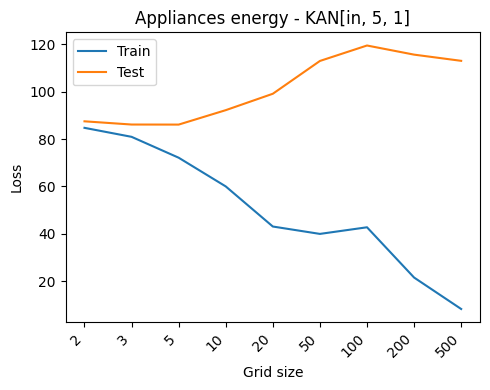

In [8]:
display_plots_grid(get_ds_name(ds_id), grid_sizes, best_train_losses, test_losses)